In [28]:
import csv
import gzip
from datetime import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model

In [29]:
dataDir = "car_prices.csv.gz"

In [30]:
dataset = []
header = []
total = 0
count = 0
errCount = 0

with gzip.open(dataDir, 'rt', encoding="utf8") as file:
    reader = csv.reader(file)
    for row in reader:
        if count == 0:
            header = row
        else:
            total += 1
            d = dict(zip(header, row))
            try:
                d['year'] = int(d['year'])
                d['condition'] = float(d['condition'])
                d['odometer'] = int(d['odometer'])
                d['mmr'] = int(d['mmr'])
                d['sellingprice'] = int(d['sellingprice'])
                d['saledate'] = ' '.join(d['saledate'].split(' ')[:5])
                d['saledate'] = dt.strptime(d['saledate'], '%a %b %d %Y %H:%M:%S')
            except ValueError: # clean data
                errCount += 1
                continue
            dataset.append(d)
        count += 1

In [31]:
dataset[2895]

{'year': 2008,
 'make': 'Honda',
 'model': 'Accord',
 'trim': 'EX-L',
 'body': 'Sedan',
 'transmission': 'automatic',
 'vin': 'jhmcp26878c032485',
 'state': 'ca',
 'condition': 2.5,
 'odometer': 114179,
 'color': 'green',
 'interior': 'black',
 'seller': 'ahfc/honda lease trust/hvt, inc.',
 'mmr': 8650,
 'sellingprice': 8600,
 'saledate': datetime.datetime(2014, 12, 18, 12, 0)}

In [56]:
errCount, count, total

(11849, 546989, 558837)

In [34]:
df = pd.DataFrame(dataset)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546988 entries, 0 to 546987
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          546988 non-null  int64         
 1   make          546988 non-null  object        
 2   model         546988 non-null  object        
 3   trim          546988 non-null  object        
 4   body          546988 non-null  object        
 5   transmission  546988 non-null  object        
 6   vin           546988 non-null  object        
 7   state         546988 non-null  object        
 8   condition     546988 non-null  float64       
 9   odometer      546988 non-null  int64         
 10  color         546988 non-null  object        
 11  interior      546988 non-null  object        
 12  seller        546988 non-null  object        
 13  mmr           546988 non-null  int64         
 14  sellingprice  546988 non-null  int64         
 15  saledate      546

In [36]:
df.nunique(axis=0)

year                34
make                94
model              960
trim              1922
body                87
transmission         3
vin             538772
state               38
condition           41
odometer        169481
color               21
interior            18
seller           12962
mmr               1101
sellingprice      1865
saledate          3721
dtype: int64

In [37]:
df.describe()

,year,condition,odometer,mmr,sellingprice
count,546988.000000,546988.000000,546988.000000,546988.000000,546988.000000
mean,2010.134301,3.424564,67262.638186,13915.646367,13764.328400
std,3.906344,0.949415,52793.170543,9674.331700,9747.756735
min,1982.000000,1.000000,1.000000,25.000000,1.000000
25%,2008.000000,2.700000,28050.750000,7375.000000,7100.000000
50%,2012.000000,3.600000,51222.000000,12400.000000,12300.000000
75%,2013.000000,4.200000,97391.250000,18450.000000,18300.000000
max,2015.000000,5.000000,999999.000000,182000.000000,230000.000000


In [38]:
df.isnull().values.any()

False

In [39]:
##### Visualizing attributes and relationships #####

(1.961873948585821,)

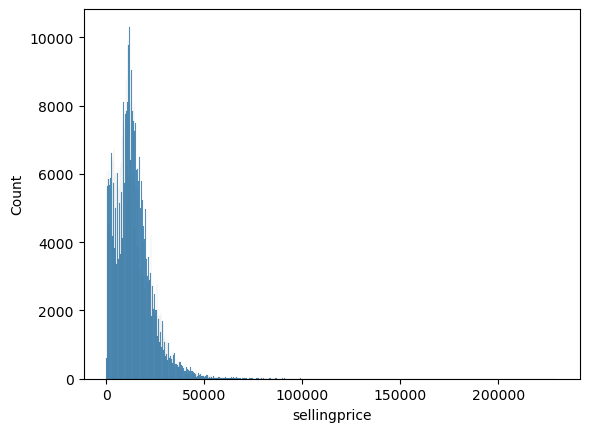

In [40]:
# sellingprices
sns.histplot(data=df, x='sellingprice')
df['sellingprice'].skew(), 

make
Rolls-Royce    153488.235294
Ferrari        127210.526316
Lamborghini    112625.000000
Bentley         74349.130435
airstream       71000.000000
                   ...      
dodge tk          550.000000
Geo               528.947368
dot               500.000000
ford truck        483.333333
Daewoo            450.000000
Name: sellingprice, Length: 94, dtype: float64

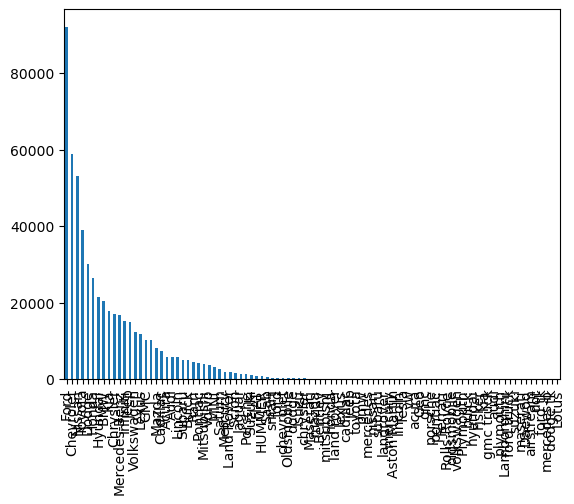

In [41]:
# make - sellingprice
df['make'].value_counts().plot(kind='bar')
df.groupby('make')['sellingprice'].mean().sort_values(ascending=False)

model
458 Italia        183000.000000
SLS AMG GT        156500.000000
i8                154222.222222
Flying Spur       154000.000000
Ghost             153488.235294
                      ...      
previa               308.333333
Spirit               300.000000
300e                 300.000000
Windstar Cargo       281.250000
Paseo                150.000000
Name: sellingprice, Length: 960, dtype: float64

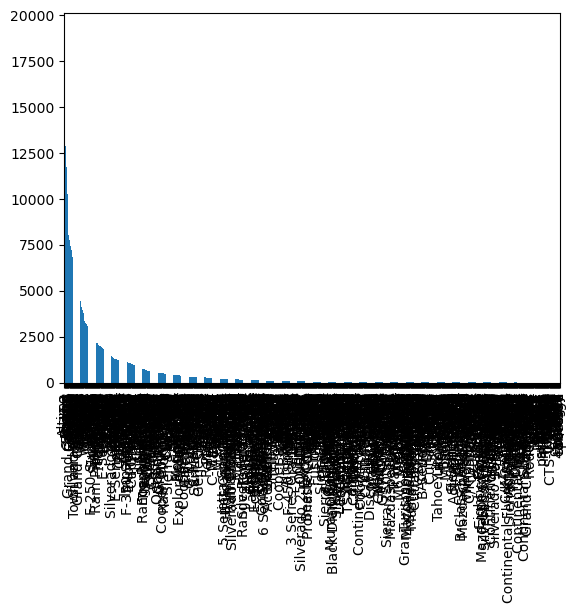

In [42]:
# model - sellingprice
df['model'].value_counts().plot(kind='bar')
df.groupby('model')['sellingprice'].mean().sort_values(ascending=False)

<AxesSubplot:ylabel='color'>

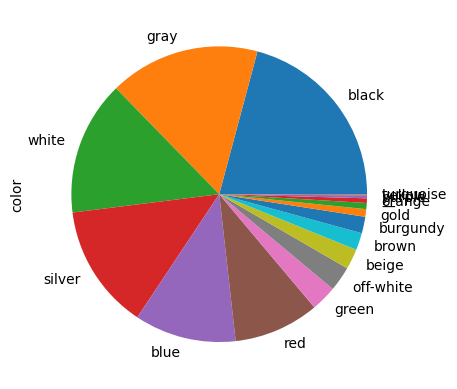

In [43]:
# color - state
# df['color'].value_counts().plot(kind='bar')

# ca_df = df.loc[df['state'] == 'ca']
# ca_df['color'].value_counts().plot(kind='pie')

ny_df = df.loc[df['state'] == 'ny']
ny_df['color'].value_counts().plot(kind='pie')

In [44]:
# color - sellingprice
df.groupby('color')['sellingprice'].mean().sort_values(ascending=False)

color
             24432.334869
—            17839.246526
charcoal     16440.427660
black        15653.189170
brown        15507.934476
off-white    15273.046788
white        14868.349666
gray         14082.469782
lime         13675.000000
orange       12919.316749
red          12844.658172
yellow       12823.642914
purple       12140.647444
burgundy     12085.618424
silver       11926.880330
pink         11823.170732
blue         11596.217820
beige         9631.114826
turquoise     8562.013216
green         8516.632603
gold          8493.704754
Name: sellingprice, dtype: float64

In [45]:
# state - sellingprice
df.groupby('state')['sellingprice'].mean().sort_values(ascending=False)

state
on    18717.674275
tn    17013.358778
pa    15992.830606
co    15916.296897
nv    15354.623995
il    15277.771237
mi    15039.378242
ca    14669.425948
mo    14558.442300
oh    14466.638717
wi    14189.333333
mn    14164.020799
wa    14044.501024
fl    14012.838824
nj    13710.607684
tx    13367.856909
qc    13285.570740
ne    13111.548190
ga    12977.671891
ny    12402.560680
ut    12262.332586
hi    12220.478508
az    11877.662544
or    11577.734375
ms    11244.130200
ab    11187.634989
la    10986.380267
in    10721.939736
sc    10471.657227
ns    10213.114754
pr     9472.567518
al     9142.307692
nc     8711.192910
va     8699.707248
ok     7782.500000
md     7458.833697
ma     6781.325165
nm     6291.812865
Name: sellingprice, dtype: float64

In [46]:
# trim - sellingprice
df.groupby('trim')['sellingprice'].mean().sort_values(ascending=False)

trim
EWB                  169000.000000
Autobiography LWB    135000.000000
Spider F1            117000.000000
S63 AMG 4MATIC       114333.333333
G63 AMG              112906.250000
                         ...      
fwd ext                 300.000000
Olympic Gold            300.000000
Estate                  300.000000
4x2 ext base            300.000000
sl                      275.000000
Name: sellingprice, Length: 1922, dtype: float64

In [47]:
# transmission - sellingprice
df.groupby('transmission')['sellingprice'].mean().sort_values(ascending=False)

transmission
             14997.254574
automatic    13683.459432
manual       11387.007334
Name: sellingprice, dtype: float64

In [48]:
# body - sellingprice
df.groupby('body')['sellingprice'].mean().sort_values(ascending=False)

body
granturismo convertible    79041.666667
GranTurismo Convertible    74000.000000
CTS-V Wagon                50500.000000
cts-v coupe                39707.142857
CTS-V Coupe                38024.851852
                               ...     
Xtracab                     5756.578947
xtracab                     5250.000000
Club Cab                    4782.587413
Cab Plus                    3266.666667
Ram Van                     1200.000000
Name: sellingprice, Length: 87, dtype: float64

In [49]:
# seller - sellingprice
df.groupby('seller')['sellingprice'].mean().sort_values(ascending=False)

seller
phelps auto sales                           161000.000000
financial services remarketing (bmw int)    153222.222222
autolink sales llc                          134500.000000
chings trading                              134000.000000
carbiz solutions, inc.                      133000.000000
                                                ...      
sindibad auto sale llc                         200.000000
beaverton honda                                200.000000
american red cross/lehigh valley               200.000000
republic finance llc/pearl                     200.000000
titlemax/manning sc1                           150.000000
Name: sellingprice, Length: 12962, dtype: float64

In [57]:
# interior - sellingprice
df.groupby('interior')['sellingprice'].mean().sort_values(ascending=False)

interior
off-white    29103.678038
             24432.334869
red          23985.594796
brown        20412.065743
orange       19683.680556
burgundy     19664.136126
white        18909.421053
yellow       18226.315789
black        15722.120825
beige        13399.784814
purple       13306.909910
tan          12568.929980
—            12296.910342
gold         11449.845201
gray         11131.011386
silver       10772.125115
green        10147.406639
blue          8397.432432
Name: sellingprice, dtype: float64

In [50]:
# vin - sellingprice
df.groupby('vin')['sellingprice'].mean().sort_values(ascending=False)

vin
1fmcu9j98eua23833    230000.0
zff67nfa1b0178698    183000.0
wddug7kb2fa102347    173000.0
sca664s52dux52152    171500.0
sca664s58cux50727    169500.0
                       ...   
4a3aj56g1ve148491       100.0
2fahp71v99x109403       100.0
1fafp55222a271061       100.0
1ftne2ew6eda13643         1.0
4s2cm58v9s4375559         1.0
Name: sellingprice, Length: 538772, dtype: float64

<AxesSubplot:>

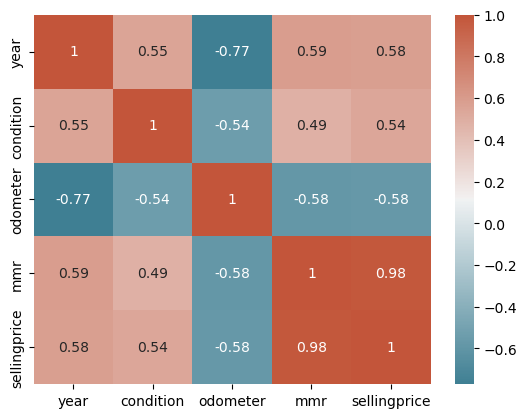

In [51]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [ ]:
# drop vin

In [52]:
# Models - Linear Regression, Random Forest Regression, KNN (K Nearest Neighbor) regression, XG Boost Regression, Decision Tree Regression, Multiple Linear Regression

In [53]:
# Linear Regression